In [136]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [137]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import visual_behavior.data_access.utilities as utilities
from visual_behavior.data_access import loading as loading

import visual_behavior.visualization.utils as utils
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

### load experiments table

In [139]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
# experiments_table = cache.get_ophys_experiments()
# print(cache_dir)

In [140]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


In [141]:
cells_table = loading.get_cell_table()
print(len(cells_table.cell_specimen_id.unique()))

28833


### get useful info

In [142]:
experience_levels = np.sort(experiments_table.experience_level.unique())
cell_types = np.sort(experiments_table.cell_type.unique())[::-1]
palette = utilities.get_experience_level_colors()

In [143]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_2'

### load multi_session_mean_df

In [144]:
def get_conditions_string(data_type, conditions):
    """
    creates a string containing the data_type and conditions corresponding to a given multi_session_df.
    ignores first element in conditions which is usually 'cell_specimen_id' or 'ophys_experiment_id'
    :param data_type: 'events', 'filtered_events', 'dff'
    :param conditions: list of conditions used to group for averaging in multi_session_df
                        ex: ['cell_specimen_id', 'is_change', 'image_name'], or ['cell_specimen_id', 'engagement_state', 'omitted']
    """

    if len(conditions) == 6:
        conditions_string = data_type + '_' + conditions[1] + '_' + conditions[2] + '_' + conditions[3] + '_' + conditions[4] + '_' + conditions[5]
    elif len(conditions) == 5:
        conditions_string = data_type + '_' + conditions[1] + '_' + conditions[2] + '_' + conditions[3] + '_' + conditions[4]
    elif len(conditions) == 4:
        conditions_string = data_type + '_' + conditions[1] + '_' + conditions[2] + '_' + conditions[3]
    elif len(conditions) == 3:
        conditions_string = data_type + '_' + conditions[1] + '_' + conditions[2]
    elif len(conditions) == 2:
        conditions_string = data_type + '_' + conditions[1]
    elif len(conditions) == 1:
        conditions_string = data_typ + '_' + conditions[0]
        
    return conditions_string

In [145]:
def get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria='full_dataset'):
    
    # params for stim_response_df to use
    time_window = [-3, 3.1]
    interpolate = True
    output_sampling_rate = 30
    response_window_duration_seconds = 0.5
    use_extended_stimulus_presentations = False


    multi_session_df = loading.load_multi_session_df(data_type=data_type, event_type=event_type, conditions=conditions, 
                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate)
    print('there are', len(multi_session_df.ophys_experiment_id.unique()), 'experiments in the full multi_session_df')

    # limit to platform expts
    platform_experiments = loading.get_platform_paper_experiment_table()
    multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(platform_experiments.index.values)]
    print('there are', len(multi_session_df.ophys_experiment_id.unique()), 'experiments in the multi_session_df after limiting to platform experiments')
    
    # merge with metadata
    multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')

    multi_session_df = multi_session_df.reset_index(drop=True)
    
#     missing_expts = loading.check_whether_multi_session_df_has_all_platform_experiments(multi_session_df)
    
    # need to filter for active first so that subsequent criteria area applied to that set
    if 'active_only' in inclusion_criteria:
        multi_session_df = multi_session_df[multi_session_df.passive==False]

    if 'closest_familiar_and_novel' in inclusion_criteria:
        multi_session_df = utilities.limit_to_last_familiar_second_novel_active(multi_session_df)

    if 'containers_with_all_levels' in inclusion_criteria:
        multi_session_df = utilities.limit_to_containers_with_all_experience_levels(multi_session_df)

    print('there are', len(multi_session_df.ophys_experiment_id.unique()), 'experiments after filtering for inclusion criteria - ', inclusion_criteria)
    
    return multi_session_df

In [73]:
# params for stim response df creation
data_type = 'events'
event_type = 'changes'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']

# name of folder for saving figures using this mdf
folder = 'changes_all_stim'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'active_only'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'
suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


## timescales analysis - epochs

In [146]:
def annotate_epoch_df(epoch_df): 
    """
    Removes truncated 7th epoch and adds 'experience_epoch' column to plot epochs per experience level
    """
    
    # get rid of short 7th epoch (just a few mins at end of session)
    epoch_df = epoch_df[epoch_df.epoch!=6]

    # add experience epoch column
    def merge_experience_epoch(row):
        return row.experience_level+' epoch '+str(int(row.epoch)+1)

    epoch_df['experience_epoch'] = epoch_df[['experience_level', 'epoch']].apply(axis=1, func=merge_experience_epoch)
    
    return epoch_df

### plot fig 2

In [147]:
import figrid as fg
import figrid.example_figures as example_figures
import matplotlib.pyplot as plt
from visual_behavior_platform_paper.utilities import plotting as plotting_utilities

In [148]:
def make_figure_2(multi_session_df, multi_session_epoch_df, data_type, event_type):
    """
    multi_session_df: dataframe with rows for cell_specimen_ids / ophys_experiment_ids containing columns for
                        'mean_trace', 'trace_timestamps', 'mean_response', 'p_value_significant_gray_screen'
                        for a set of conditions
    multi_session_epoch_df: dataframe containing the same information, but grouped by 10 minute epochs within sessions
                            dataframe should have column 'experience_epoch' in addition to those listed above
    data_type: 'events', 'filtered_events', 'dff', 'pupil_width', 'running_speed', or 'lick_rate'
    event_type: 'changes', 'omissions', or 'all'
    """

#     sns.despine(offset=10, trim=True);
    
    # define the figure panel
#     figure = plt.figure(figsize=(11,8.5))
    figure = plt.figure(figsize=(11*1.2,8.5*1.2))

    # for mean response epochs plot, set ymin to 0 when looking at physio but do not set ymin otherwise
    if ('pupil' in data_type) or ('running' in data_type) or ('lick' in data_type):
        behavior = True
        ylim = None
        ymin = None
    else: 
        behavior = False
        ylim = (0,1)
        ymin = 0
        

    # define the axes, including their relative location, using figrid
    ax = {
        'panel_A': fg.place_axes_on_grid(figure, xspan=[0.05, 0.3], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
        'panel_B': fg.place_axes_on_grid(figure, xspan=[0.425, 0.6], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
        'panel_C': fg.place_axes_on_grid(figure, xspan=[0.725, 1], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
    }

    # call functions that make plots
    palette = utilities.get_experience_level_colors()
    ax['panel_A'] = ppf.plot_population_averages_for_conditions(multi_session_df, data_type, event_type, 
                                            axes_column='cell_type', hue_column='experience_level', 
                                            xlim_seconds=[-1, 1.5], palette=palette, horizontal=False, 
                                            save_dir=None, folder=None, 
                                            suffix=suffix, ax=ax['panel_A'])
    
    if behavior: # if its a behavior data_type use mean response
        ax['panel_B'] = ppf.plot_average_metric_value_for_experience_levels_across_containers(multi_session_df, metric='mean_response',
                                                                                              ylim=ylim, horizontal=True, save_dir=None, 
                                                                                              folder=None, suffix='', ax=ax['panel_B'])
    else: # plot responsive cells
        ax['panel_B'] = ppf.plot_fraction_responsive_cells(multi_session_df, responsiveness_threshold=0.1, ylim=ylim,
                                    save_dir=None, folder=None, suffix=suffix, horizontal=False, ax=ax['panel_B'])

    ax['panel_C'] = ppf.plot_mean_response_by_epoch(multi_session_epoch_df, metric='mean_response', 
                                                    horizontal=False, ymin=ymin,
                                                    save_dir=None, folder=None, suffix=suffix, ax=ax['panel_C'])
        
    # add labels
    labels = [
        {'label_text':'A', 'xpos':0, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
        {'label_text':'B', 'xpos':0.325, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
        {'label_text':'C', 'xpos':0.65, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
    ]
    fg.add_labels(figure, labels)
    
#     sns.despine(offset=10, trim=True);

    return figure

### generate for multiple conditions

In [77]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_2'

### changes, events, full dataset

In [78]:
# # params for stim response df creation
# data_type = 'events'
# event_type = 'changes'

# # set inclusion criteria
# # options: [full_session', active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# # change response
# conditions = ['cell_specimen_id', 'is_change']
# change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

# # set suffix for figure saving
# suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

# # change response over epochs
# conditions = ['cell_specimen_id', 'is_change', 'epoch']
# change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)
# change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)

# figure = make_figure_2(change_mdf, change_epoch_mdf, data_type, event_type)

# # utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, folder='final_panels_overlay', fig_title=suffix)

### New version of fig 2 with separate panels for pop avgs

In [79]:
def plot_population_averages_for_cell_types_across_experience(multi_session_df, xlim_seconds=[-1.25, 1.5], 
                                                              save_dir=None, folder=None, ax=None):
    
    
    # get important information
    experiments_table = loading.get_platform_paper_experiment_table()
    experience_levels = np.sort(experiments_table.experience_level.unique())
    cell_types = np.sort(experiments_table.cell_type.unique())[::-1]
    palette = utilities.get_experience_level_colors()

    # define plot axes
    axes_column = 'experience_level'
    hue_column = 'experience_level'
    
    if ax is None: 
        format_fig = True
        figsize=(10,8)
        fig, ax = plt.subplots(3,3, figsize=figsize, sharey='row', sharex='col')
        ax = ax.ravel()
    else:
        format_fig = False
        

    for i, cell_type in enumerate(cell_types):
        df = multi_session_df[(multi_session_df.cell_type==cell_type)]
        if format_fig:
            ax[i*3:(i*3+3)] = ppf.plot_population_averages_for_conditions(df, data_type, event_type, 
                                                    axes_column, hue_column, horizontal=True,
                                                    xlim_seconds=xlim_seconds, palette=palette, 
                                                    ax=ax[i*3:(i*3+3)])
        else: 
            ax[i] = ppf.plot_population_averages_for_conditions(df, data_type, event_type, 
                                                    axes_column, hue_column, horizontal=True,
                                                    xlim_seconds=xlim_seconds, palette=palette, 
                                                    ax=ax[i])
            
            
    if format_fig:        
        for i in [0,3,6]:
            ax[i].set_ylabel('population\nresponse')
        for i in np.arange(3,9):
            ax[i].set_title('')
        for i in np.arange(0,6):
            ax[i].set_xlabel('')
        fig.tight_layout()
    else:
        for i in range(len(cell_types)):
            ax[i][0].set_ylabel('population\nresponse')
        for i in np.arange(1,3):
            for x in range(3):
                ax[i][x].set_title('')
        for i in np.arange(0,2):
            for x in range(3):
                ax[i][x].set_xlabel('')
#         for i in np.arange(0,3):
#             for x in [0]:
#                 ax[i][x].set_yticklabels('')
        
        
    if save_dir:
        fig_title = 'population_average_cell_types_exp_levels'+ suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title, formats=['.png', '.pdf'])
 
    return ax


In [80]:
def make_figure_2(multi_session_df, data_type, event_type):
    """
    multi_session_df: dataframe with rows for cell_specimen_ids / ophys_experiment_ids containing columns for
                        'mean_trace', 'trace_timestamps', 'mean_response', 'p_value_significant_gray_screen'
                        for a set of conditions
    multi_session_epoch_df: dataframe containing the same information, but grouped by 10 minute epochs within sessions
                            dataframe should have column 'experience_epoch' in addition to those listed above
    data_type: 'events', 'filtered_events', 'dff', 'pupil_width', 'running_speed', or 'lick_rate'
    event_type: 'changes', 'omissions', or 'all'
    """

    #     sns.despine(offset=10, trim=True);

    # define the figure panel
    #     figure = plt.figure(figsize=(11,8.5))
    figure = plt.figure(figsize=(11*1.2, 8.5*1.2))

    # for mean response epochs plot, set ymin to 0 when looking at physio but do not set ymin otherwise
    if ('pupil' in data_type) or ('running' in data_type) or ('lick' in data_type):
        behavior = True
        ylim = None
        ymin = None
    else: 
        behavior = False
        ylim = (0,1)
        ymin = 0


    # define the axes, including their relative location, using figrid
    ax = {
        'panel_A': fg.place_axes_on_grid(figure, xspan=[0.05, 0.65], yspan=[0.05, 0.75], dim=[3, 3], hspace=0.25, wspace=0.15, sharex=True, sharey='row'),
        'panel_B': fg.place_axes_on_grid(figure, xspan=[0.775, 0.9], yspan=[0.05, 0.75], dim=[3, 1], hspace=0.25, wspace=0.5, sharex=True),
    #     'panel_C': fg.place_axes_on_grid(figure, xspan=[0.725, 1], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
    #     'panel_D': fg.place_axes_on_grid(figure, xspan=[0.725, 1], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
    #     'panel_E': fg.place_axes_on_grid(figure, xspan=[0.725, 1], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
    #     'panel_F': fg.place_axes_on_grid(figure, xspan=[0.725, 1], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
    }

    # call functions that make plots

    # ax['panel_A'] = ax.ravel()
    ax['panel_A'] = plot_population_averages_for_cell_types_across_experience(multi_session_df, xlim_seconds=[-1.25, 1.5], 
                                                                              ax=ax['panel_A'])
    
    
    if behavior: # if its a behavior data_type use mean response
        ax['panel_B'] = ppf.plot_average_metric_value_for_experience_levels_across_containers(multi_session_df, metric='mean_response',
                                                                                              ylim=ylim, horizontal=True, save_dir=None, 
                                                                                              folder=None, suffix='', ax=ax['panel_B'])
    else: # plot responsive cells
        ax['panel_B'] = ppf.plot_fraction_responsive_cells(multi_session_df, responsiveness_threshold=0.1, ylim=ylim,
                                    save_dir=None, folder=None, suffix=suffix, horizontal=False, ax=ax['panel_B'])

    # ax['panel_C'] = ppf.plot_mean_response_by_epoch(multi_session_epoch_df, metric='mean_response', 
    #                                                 horizontal=False, ymin=ymin,
    #                                                 save_dir=None, folder=None, suffix=suffix, ax=ax['panel_C'])

    # add labels
    labels = [
        {'label_text':'A', 'xpos':0, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
        {'label_text':'B', 'xpos':0.7, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
    #     {'label_text':'C', 'xpos':0.95, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
    ]
    fg.add_labels(figure, labels)

    #     sns.despine(offset=10, trim=True);

    return figure

In [81]:
# params for stim response df creation
data_type = 'events'
event_type = 'changes'

# set inclusion criteria
# options: [full_session', active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# change response
conditions = ['cell_specimen_id', 'is_change']
change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

# set suffix for figure saving
suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria


there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028A9FFEAB70>,
      dtype=object)

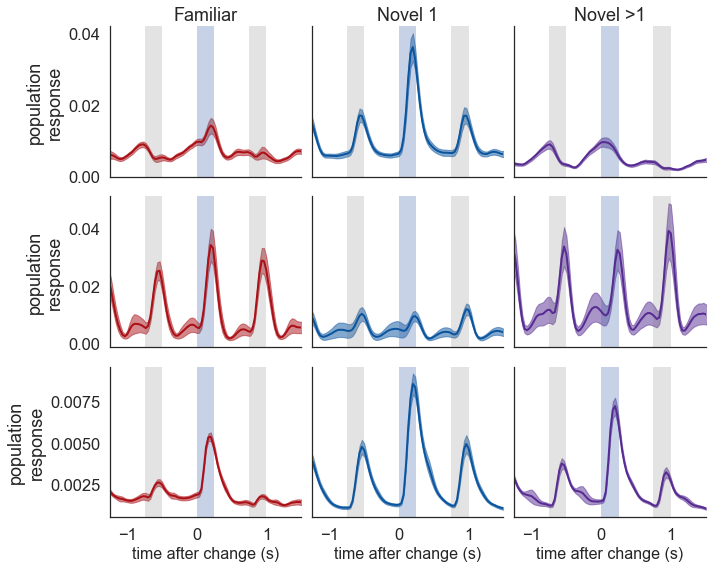

In [82]:
df = change_mdf.copy()

plot_population_averages_for_cell_types_across_experience(df, xlim_seconds=[-1.25, 1.5], 
                                                              save_dir=save_dir, folder='population_average', ax=None)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028AA01B8438>,
      dtype=object)

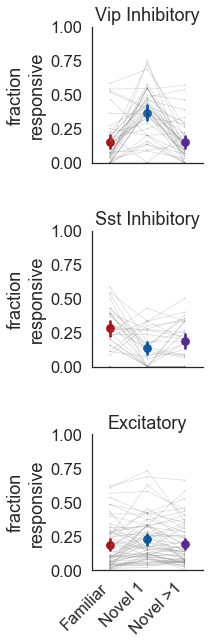

In [111]:
ppf.plot_fraction_responsive_cells(change_mdf, responsiveness_threshold=0.1, ylim=(0,1),
                                    save_dir=save_dir, folder='metric_distributions', suffix=suffix, horizontal=False, ax=None)

In [84]:
# figure = make_figure_2(change_mdf, data_type, event_type)

# utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, folder='population_average', fig_title=suffix,  formats=['.png', '.pdf'])

## mean response, exp and change mod

### get cell metrics table for changes

In [113]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm


In [114]:
ophys_experiment_ids = experiments_table.index.values

condition = 'changes'
stimuli = 'all_images'
session_subset = 'full_session'
data_type = 'events'

# set inclusion criteria
# options: ['full_dataset', 'active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'full_dataset'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# metrics_table = get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, 
#                                                 inclusion_criteria=inclusion_criteria)
    
metrics_table = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

  0%|▏                                                                                 | 1/402 [00:00<01:01,  6.51it/s]

there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [01:11<00:00,  5.60it/s]
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['condition', 'data_type', 'exception', 'filter_events', 'interpolate', 'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events']]




there are 402 experiments in the returned cell_metrics table


In [115]:
original_metrics_table = metrics_table.copy()

### save descriptive statistics for all metrics

In [116]:
def get_metrics_descriptive_stats_filename(conditions, data_type, condition, stimuli, session_subset, inclusion_criteria):
    """
    generates filename to save descriptive statistics computed for a set of conditions from cell metrics table
    input params are defined in cell_metrics.get_cell_metrics_for_conditions() 
    """
    if len(conditions) == 6:
        filename = 'metrics_stats_'+conditions[0]+'_'+conditions[1]+'_'+conditions[2]+'_'+conditions[3]+'_'+conditions[4]+'_'+conditions[5]+'_'+data_type+'_'+condition+'_'+stimuli+'_'+session_subset+'_'+inclusion_criteria
    elif len(conditions) == 5:
        filename = 'metrics_stats_'+conditions[0]+'_'+conditions[1]+'_'+conditions[2]+'_'+conditions[3]+'_'+conditions[4]+'_'+data_type+'_'+condition+'_'+stimuli+'_'+session_subset+'_'+inclusion_criteria   
    elif len(conditions) == 4:
        filename = 'metrics_stats_'+conditions[0]+'_'+conditions[1]+'_'+conditions[2]+'_'+conditions[3]+'_'+data_type+'_'+condition+'_'+stimuli+'_'+session_subset+'_'+inclusion_criteria   
    elif len(conditions) == 3:
        filename = 'metrics_stats_'+conditions[0]+'_'+conditions[1]+'_'+conditions[2]+'_'+data_type+'_'+condition+'_'+stimuli+'_'+session_subset+'_'+inclusion_criteria   
    elif len(conditions) == 2:
        filename = 'metrics_stats_'+conditions[0]+'_'+conditions[1]+'_'+data_type+'_'+condition+'_'+stimuli+'_'+session_subset+'_'+inclusion_criteria   
    elif len(conditions) == 1:
        filename = 'metrics_stats_'+conditions[0]+'_'+data_type+'_'+condition+'_'+stimuli+'_'+session_subset+'_'+inclusion_criteria     
    return filename

In [117]:
def get_descriptive_stats_for_conditions(metrics_table, conditions=['cell_type', 'experience_level'], save_dir=None, filename=None):
    """
    compute and save descriptive statistics for cell metrics for a set of conditions (ex: ['cell_type', 'experience_level'])
    """
    metrics = ['cell_specimen_id', 'mouse_id', 'ophys_session_id', 'ophys_container_id', 'ophys_experiment_id', 
               'image_selectivity_index', 'image_selectivity_index_one_vs_all',
               'lifetime_sparseness', 'mean_response',
               'fraction_significant_p_value_gray_screen', 'fano_factor',
               'reliability', 'running_modulation_index', 'hit_miss_index',
               'change_response', 'pre_change', 'pre_change_response',
               'change_modulation_index']

    metrics_stats = metrics_table[metrics+conditions].groupby(conditions).describe()
    stats_dir = os.path.join(save_dir, 'descriptive_statistics')
    if not os.path.exists(stats_dir):
        os.mkdir(stats_dir)
    metrics_stats.to_hdf(os.path.join(stats_dir, filename+'.h5'), key='df')
    return metrics_stats

In [118]:
def load_descriptive_stats_for_conditions(conditions, save_dir, filename):
    stats_dir = os.path.join(save_dir, 'descriptive_statistics')
    metrics_stats = pd.read_hdf(os.path.join(stats_dir, filename+'.h5'), key='df')
    return metrics_stats

In [119]:
# conditions = ['cell_type', 'experience_level']
# filename = get_metrics_descriptive_stats_filename(conditions, data_type, condition, stimuli, session_subset, inclusion_criteria)
# metrics_stats = get_descriptive_stats_for_conditions(metrics_table, conditions, save_dir, filename)

# conditions = ['cell_type', 'experience_level', 'targeted_structure']
# filename = get_metrics_descriptive_stats_filename(conditions, data_type, condition, stimuli, session_subset, inclusion_criteria)
# metrics_stats = get_descriptive_stats_for_conditions(metrics_table, conditions, save_dir, filename)


# conditions = ['cell_type', 'experience_level', 'layer']
# filename = get_metrics_descriptive_stats_filename(conditions, data_type, condition, stimuli, session_subset, inclusion_criteria)
# metrics_stats = get_descriptive_stats_for_conditions(metrics_table, conditions, save_dir, filename)


# conditions = ['cell_type', 'experience_level', 'targeted_structure', 'layer']
# filename = get_metrics_descriptive_stats_filename(conditions, data_type, condition, stimuli, session_subset, inclusion_criteria)
# metrics_stats = get_descriptive_stats_for_conditions(metrics_table, conditions, save_dir, filename)

In [120]:
# metrics_stats = load_descriptive_stats_for_conditions(conditions, save_dir, filename)

### emulate Alex's statistics for experience levels

In [121]:
from scipy import stats
import statsmodels.stats.multicomp as mc

def test_significant_dropout_averages(data, metric):
    """
    run one way anova across experience levels for a given metric in data
    data: cell metrics dataframe, each row is one cell_specimen_id in a given ophys_experiment
    metric: column in data representing metric values of interest
    """
    data = data[~data[metric].isnull()].copy()
    anova = stats.f_oneway(
        data.query('experience_level == "Familiar"')[metric],  
        data.query('experience_level == "Novel >1"')[metric],  
        data.query('experience_level == "Novel 1"')[metric]
        )
    comp = mc.MultiComparison(data[metric], data['experience_level'])
    post_hoc_res = comp.tukeyhsd()
    tukey_table = pd.read_html(post_hoc_res.summary().as_html(),header=0, index_col=0)[0]
    tukey_table = tukey_table.reset_index()
    mapper = {
        'Familiar':0,
        'Novel 1':1,
        'Novel >1':2,
        }
    tukey_table['x1'] = [mapper[str(x)] for x in tukey_table['group1']]
    tukey_table['x2'] = [mapper[str(x)] for x in tukey_table['group2']]
    tukey_table['one_way_anova_p_val'] = anova[1]
    return anova, tukey_table

In [122]:
anova, tukey_table = test_significant_dropout_averages(metrics_table, 'change_modulation_index')
tukey_table

,group1,group2,meandiff,lower,upper,reject,x1,x2,one_way_anova_p_val
0,Familiar,Novel 1,0.0764,0.0595,0.0934,True,0,1,3.886419e-25
1,Familiar,Novel >1,0.0332,0.0159,0.0504,True,0,2,3.886419e-25
2,Novel 1,Novel >1,-0.0433,-0.0601,-0.0264,True,1,2,3.886419e-25


In [123]:
def add_experience_level_stats(data, metric, colors, ax, ymax=None):
    """
    add stars to axis indicating across experience level statistics
    x-axis of plots must be experience_levels 
    """
    # do anova across experience levels followed by post-hoc tukey
    anova, tukey = test_significant_dropout_averages(data, metric)
    
    scale = 0.1
    fontsize = 12
    
    if ymax is None:
        ytop = ax.get_ylim()[1]
    else:
        ytop = ymax
    y1 = ytop
    y1h = ytop*(1+scale)
    y2 = ytop*(1+scale*2)
    y2h = ytop*(1+scale*3)

    if anova.pvalue<0.05:
        for tindex, row in tukey.iterrows():
            if row.x2-row.x1 > 1:
                y = y2
                yh = y2h
            else:
                y = y1
                yh = y1h 
            if row.reject:
                ax.plot([row.x1,row.x1,row.x2,row.x2],[y,yh,yh,y],'k-')
                ax.text(np.mean([row.x1,row.x2]),yh, '*', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')
            else:
                ax.plot([row.x1,row.x1,row.x2,row.x2],[y,yh,yh,y],'k-')
                ax.text(np.mean([row.x1,row.x2]),yh, 'ns', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')
    else:
        y = y1
        yh = y1h
        ax.plot([0,0,1,1,1,2,2], [y,yh,yh,y,yh,yh,y], 'k-')
        ax.text(.95,ytop*(1+scale*1.5), 'ns', color='k', fontsize=fontsize)
    ax.set_ylim(ymax=ytop*(1+scale*4))
    
    return ax, tukey

In [124]:
def plot_metric_distribution_by_experience(metrics_table, metric, hue=None, stripplot=False, pointplot=False,
                                           ylabel=None, ylims=None, save_dir=None, ax=None, prefix=''):
    """
    plot metric distribution across experience levels for each cell_type in metrics_table, with stats across experience levels
    if hue is provided, plots will be split by hue column and stats will be done on hue column differences instead of across experience levels
    plots boxplot by default, can add stripplot (if no hue is provided) or use pointplot instead
    
    metrics_table: cell metrics table, each row is one cell_specimen_id in one ophys_experiment_id
    metric: column in metrics_table containing metric values, metrics will be plotted using experience level colors unless a hue is provided
    hue: column in metrics_table to split metric values by for plotting (ex: 'targeted_structure')
                plots using hue will have 'gray' as palette
    stripplot: Bool, if True, plots each individual cell as swarmplot along with boxplot
                only works when no hue is provided
                if cell_type is 'Excitatory', only shows 25% of cells due to high density
    pointplot: Bool, if True, will use pointplot instead of boxplot and/or stripplot
    ylims: yaxis limits to use; if None, will use +/-1
    save_dir: directory to save to. if None, plot will not be saved
    ax: axes to plot figures on
    """
    data = metrics_table.copy()
    
    if hue: 
        if hue == 'targeted_structure':
            hue_order = np.sort(metrics_table[hue].unique())[::-1]
        else: 
            hue_order = np.sort(metrics_table[hue].unique())[::-1]
        suffix = '_'+hue
    else:
        suffix = '_experience_level'
    if (ylims == None) and ('modulation_index' in metric):
        ylims = (-1.1, 1.1)
        ymin = ylims[0]
        ymax = ylims[1]
        loc = 'lower right'
    elif (ylims == None) and (metric == 'mean_response'):
        ymin = 0
        ymax = None
        loc = 'upper left'
    elif ylims == None:
        print('please provide ylims')
        ymin = 0
        ymax = None
        loc = 'upper left'
    else: 
        ymin = ylims[0]
        ymax = ylims[1]
        loc = 'upper left'
    order = np.sort(metrics_table['experience_level'].unique())
    colors = utils.get_experience_level_colors()
    if ax is None: 
        figsize = (2,10)
        fig, ax = plt.subplots(3,1, figsize=figsize, sharex=True, sharey=False)
    # stats dataframe to save
    tukey = pd.DataFrame()
    cell_types = np.sort(metrics_table['cell_type'].unique())[::-1]
    for i,cell_type in enumerate(cell_types):
        ct_data = data[data.cell_type==cell_type]
        if hue: 
            if pointplot: 
                ax[i] = sns.pointplot(data=ct_data, y=metric, x='experience_level', order=order, dodge=0.3, join=False,
                                hue=hue, hue_order=hue_order, palette='gray', ax=ax[i], zorder=10**10)
            else: 
                ax[i] = sns.boxplot(data=ct_data, y=metric, x='experience_level', order=order, 
                                width=0.4, hue=hue, hue_order=hue_order, palette='gray', ax=ax[i], zorder=10**10)
            ax[i].legend(fontsize='xx-small', title='', loc=loc) #bbox_to_anchor=(1,1))
            if ylims: 
                ax[i].set_ylim(ylims)
            ### TBD add area or depth comparison stats / stats across hue variable
        else: 
            if pointplot: 
                 ax[i] = sns.pointplot(data=ct_data, x='experience_level', y=metric, 
                                            palette=colors, ax=ax[i], zorder=10**10)
            else:
                ax[i] = sns.boxplot(data=ct_data, x='experience_level', y=metric, width=0.4,
                                            palette=colors, ax=ax[i], zorder=10**10)
            if stripplot:
                ax[i] = sns.boxplot(data=ct_data, x='experience_level', y=metric, width=0.4,
                                            color='white', ax=ax[i], zorder=10**10)
                # format to have black lines and transparent box face
                plt.setp(ax[i].artists, edgecolor = 'k', facecolor=[0, 0, 0, 0], zorder=10**10)
                plt.setp(ax[i].lines, color='k', zorder=10**10)
                # add strip plot
                if cell_type == 'Excitatory':
                    ct_data = ct_data.reset_index()
                    # get 25% of all data points
                    pct=0.25
                    n_samples = int(len(ct_data)*pct)
                    print(n_samples, 'is',pct*100,'% of all', cell_type, 'cells')
                    idx = np.random.choice(np.arange(len(ct_data)), n_samples)
                    # limit to this random subset
                    ct_data = ct_data.loc[idx]
                ax[i] = sns.stripplot(data=ct_data, size=1.5, alpha=0.5, jitter=0.2,
                                            x='experience_level', y=metric, palette=colors, ax=ax[i])
            # add stats to plot if only looking at experience levels                
            ax[i], tukey_table = add_experience_level_stats(ct_data, metric, 'white', ax[i], ymax=ymax)
            # aggregate stats
            tukey_table['metric'] = metric
            tukey_table['cell_type'] = cell_type
            tukey = pd.concat([tukey, tukey_table])
            ax[i].set_ylim(ymin=ymin)
            
        # add line at y=0 
        ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
        ax[i].set_title(cell_type)
        ax[i].set_xlabel('')
        ax[i].set_xticklabels(experience_levels, rotation=45, ha='right')
        if ylabel: 
            ax[i].set_ylabel(ylabel)
        else: 
            ax[i].set_ylabel(metric)

    fig.subplots_adjust(hspace=0.3)
    if save_dir:
        folder = 'metric_distributions'
        if prefix: 
            filename = prefix+'_'+metric+'_distribution'+suffix
            stats_filename = prefix+'_'+metric+'_stats'+suffix+'.csv'
        else:
            filename = metric+'_distribution'+suffix
            stats_filename = metric+'_stats'+suffix+'.csv'
        utils.save_figure(fig, figsize, save_dir, folder, filename)
        try:
            tukey.to_csv(os.path.join(save_dir, folder, stats_filename))
        except:
            print('STATS DID NOT SAVE FOR', metric, hue)
    return ax

### change modulation

5670 is 25.0 % of all Excitatory cells


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028AA0A494E0>,
      dtype=object)

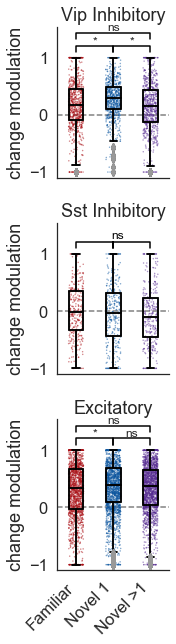

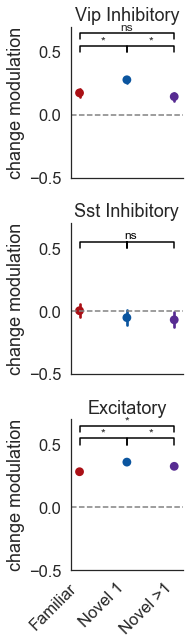

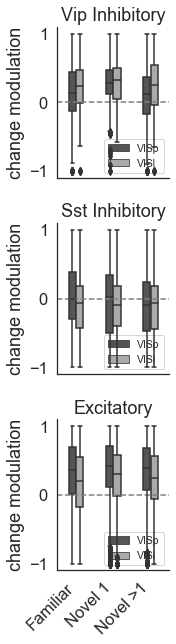

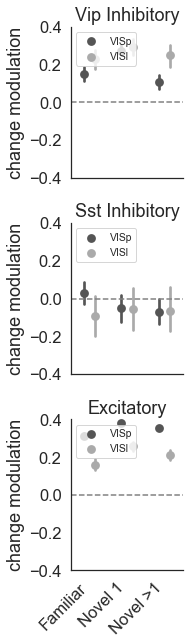

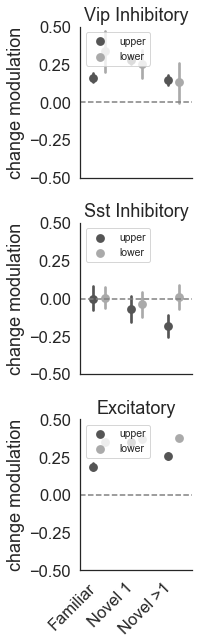

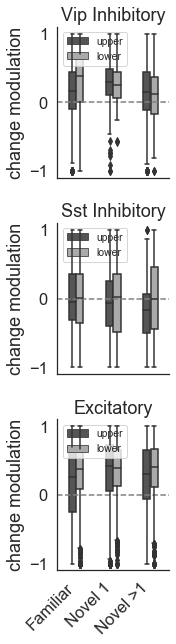

In [125]:
metric = 'change_modulation_index'

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=True, pointplot=False,
                                       ylabel='change modulation', ylims=None, save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True,
                                       ylabel='change modulation', ylims=(-0.5, 0.5), save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=False,
                                    hue='targeted_structure', ylabel='change modulation', save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True,
                                    hue='targeted_structure', ylabel='change modulation', ylims=(-0.4, 0.4), save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True,
                                    hue='layer', ylabel='change modulation', ylims=(-0.5, 0.5), save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=False,
                                    hue='layer', ylabel='change modulation', ylims=(-1.1, 1.1), save_dir=save_dir, ax=None)

### mean response differences

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028AA6B1A390>,
      dtype=object)

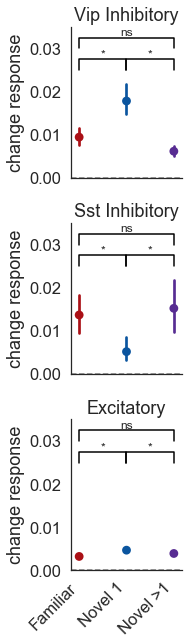

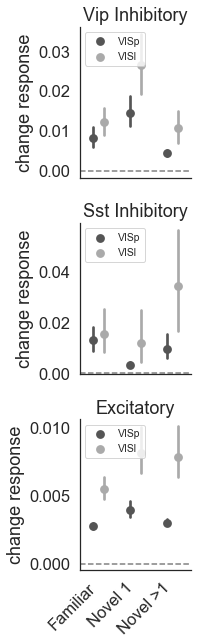

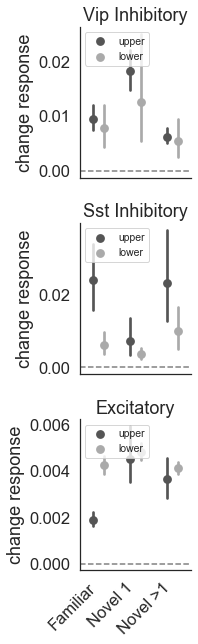

In [126]:
metric = 'mean_response'

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True, prefix=event_type,
                                       ylabel='change response', ylims=(0, 0.025), save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True, prefix=event_type,
                                    hue='targeted_structure', ylabel='change response', ylims=None, save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True, prefix=event_type,
                                    hue='layer', ylabel='change response', ylims=None, save_dir=save_dir, ax=None)


### experience modulation 

In [127]:
def compute_experience_modulation_index(metrics_table, metric, cells_table):
    """
    computes the difference over the sum of metric value between Novel 1 and Familiar, and Novel >1 and Familiar
    metrics_table: table of cell metrics, each row is one cell_specimen_id in one ophys_experiment
    metric: column in metrics table to compute index with
    cells_table: cells metadata table
    """
    # get subset of data of interest
    metric = 'mean_response'
    metric_data = metrics_table[['cell_specimen_id', 'ophys_experiment_id', metric]]

    # merge in metadata for sessions to compare
    metric_data = metric_data.merge(experiments_table.reset_index()[['ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id'])

    # groupby cell and session number then average across multiple sessions of the same type for each cell
    metric_data = metric_data.groupby(['cell_specimen_id', 'experience_level']).mean()[[metric]]
    # unstack to get metric for each session number
    metric_data = metric_data.unstack()
    # get rid of multi index column name
    metric_data.columns = metric_data.columns.droplevel(0)

    # compute modulation indices
    exp_level_1 = 'Familiar'

    exp_level_2 = 'Novel 1'
    metric_data[exp_level_2+' vs. '+exp_level_1] = (metric_data[exp_level_2]-metric_data[exp_level_1])/(metric_data[exp_level_2]+metric_data[exp_level_1])
    exp_level_2 = 'Novel >1'
    metric_data[exp_level_2+' vs. '+exp_level_1] = (metric_data[exp_level_2]-metric_data[exp_level_1])/(metric_data[exp_level_2]+metric_data[exp_level_1])

    exp_level_2 = 'Novel 1'
    metric_data[exp_level_2+' % of '+exp_level_1] = (metric_data[exp_level_2])/(metric_data[exp_level_1])
    exp_level_2 = 'Novel >1'
    metric_data[exp_level_2+' % of '+exp_level_1] = (metric_data[exp_level_2])/(metric_data[exp_level_1])

    # add cell type
    metric_data = metric_data.merge(cells_table[['cell_specimen_id', 'cell_type']], on='cell_specimen_id')
    
    return metric_data

In [128]:
def change_width(ax, new_value):
    locs = ax.get_xticks()
    for i,patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(locs[i//4] - (new_value * .5))

In [129]:
metric_data = compute_experience_modulation_index(metrics_table, metric, cells_table)
metric_data = metric_data.drop_duplicates(subset='cell_specimen_id')

df = metric_data[['cell_specimen_id', 'Novel 1 vs. Familiar', 'Novel >1 vs. Familiar', 'cell_type']]
df = df.melt(id_vars=['cell_specimen_id', 'cell_type'], var_name='comparison',
             value_vars=['Novel 1 vs. Familiar', 'Novel >1 vs. Familiar'])
df.head()

,cell_specimen_id,cell_type,comparison,value
0,1086489847,Vip Inhibitory,Novel 1 vs. Familiar,0.450261
1,1086489860,Vip Inhibitory,Novel 1 vs. Familiar,0.425829
2,1086489869,Vip Inhibitory,Novel 1 vs. Familiar,NaN
3,1086489882,Vip Inhibitory,Novel 1 vs. Familiar,NaN
4,1086489891,Vip Inhibitory,Novel 1 vs. Familiar,0.509002


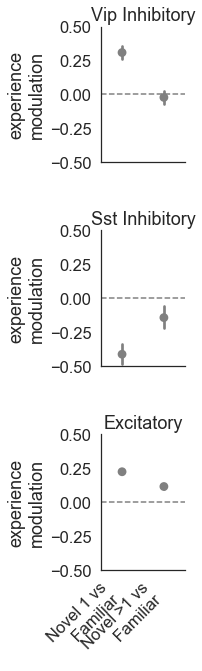

In [130]:
data = df.copy()

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

colors = utils.get_experience_level_colors()
figsize = (1.5,10)
fig, ax = plt.subplots(3,1, figsize=figsize, sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
#     ax[i] = sns.barplot(data=ct_data,  x=x, order=xorder, y=metric, dodge=0.5, ax=ax[i])
#     change_width(ax[i], 0.3) 
    ax[i] = sns.pointplot(data=ct_data, xorder=xorder, join=False,
                                x=x, y=metric, color='gray', ax=ax[i], zorder=0)

    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.5, 0.5)
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=45, ha='right')
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
# fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)
fig.subplots_adjust(hspace=0.5)
utils.save_figure(fig, figsize, save_dir, 'metric_distributions', 'experience_modulation_'+event_type)

### for omissions

In [103]:
# params for stim response df creation
data_type = 'events'
event_type = 'omissions'

# set inclusion criteria
# options: [full_session', active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# change response
conditions = ['cell_specimen_id', 'omitted']
omission_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

# set suffix for figure saving
suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria


there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


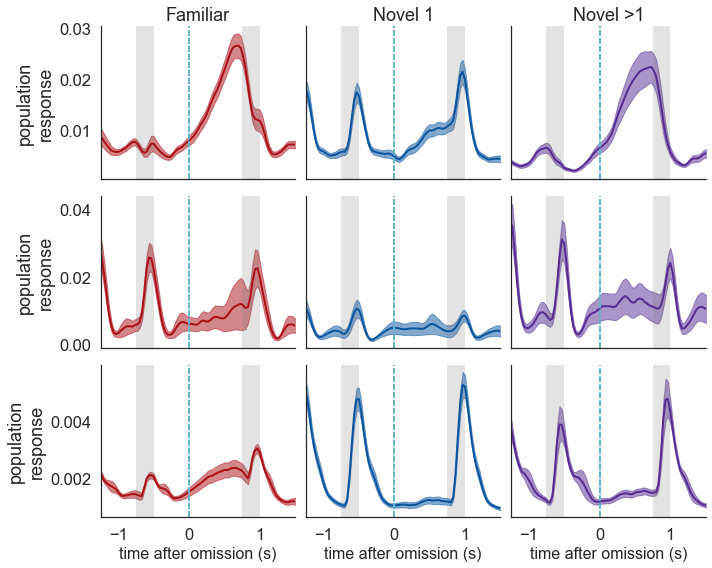

In [104]:
plot_population_averages_for_cell_types_across_experience(omission_mdf, xlim_seconds=[-1.25, 1.5], 
                                                              save_dir=save_dir, folder='population_average', ax=None);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028AD8A47C50>,
      dtype=object)

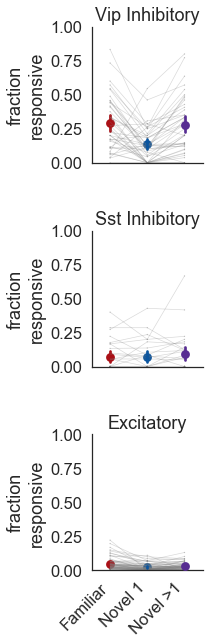

In [131]:
ppf.plot_fraction_responsive_cells(omission_mdf, responsiveness_threshold=0.1, ylim=(0,1),
                                    save_dir=save_dir, folder='metric_distributions', suffix=suffix, horizontal=False, ax=None)

In [106]:

# figure = make_figure_2(omission_mdf, data_type, event_type)

# utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, folder='population_average', fig_title=suffix, formats=['.png', '.pdf'])

### cell metrics 

In [132]:
ophys_experiment_ids = experiments_table.index.values

condition = 'omissions'
stimuli = 'all_images'
session_subset = 'full_session'
data_type = 'events'

# set inclusion criteria
# options: ['full_dataset', 'active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'full_dataset'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# metrics_table = get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, 
#                                                 inclusion_criteria=inclusion_criteria)
    
metrics_table = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

  0%|▏                                                                                 | 1/402 [00:00<00:47,  8.45it/s]

there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [01:08<00:00,  5.83it/s]
C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['condition', 'data_type', 'exception', 'filter_events', 'interpolate', 'ophys_experiment_id', 'session_subset', 'stimuli', 'use_events']]




there are 402 experiments in the returned cell_metrics table


### mean response

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028AC4D54B70>,
      dtype=object)

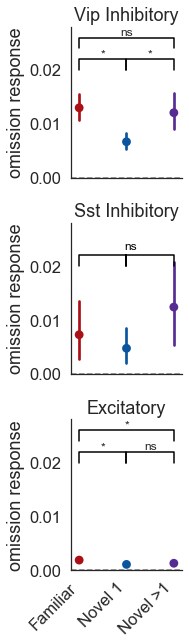

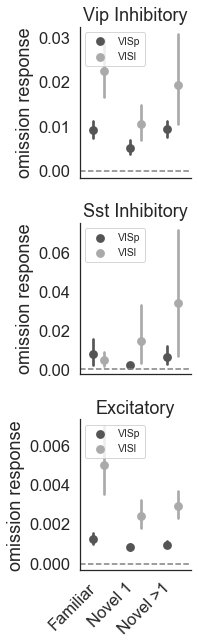

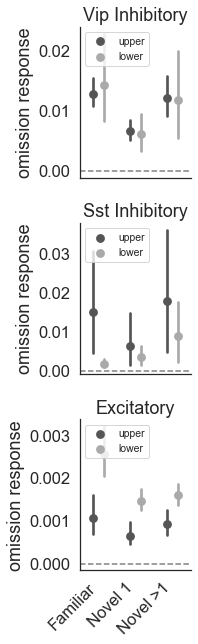

In [133]:
metric = 'mean_response'

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True, prefix=event_type,
                                       ylabel='omission response', ylims=(0, 0.02), save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True, prefix=event_type,
                                    hue='targeted_structure', ylabel='omission response', ylims=None, save_dir=save_dir, ax=None)

plot_metric_distribution_by_experience(metrics_table, metric, stripplot=False, pointplot=True, prefix=event_type,
                                    hue='layer', ylabel='omission response', ylims=None, save_dir=save_dir, ax=None)


### omission modulation by experience

In [134]:
metric_data = compute_experience_modulation_index(metrics_table, metric, cells_table)
metric_data = metric_data.drop_duplicates(subset='cell_specimen_id')

df = metric_data[['cell_specimen_id', 'Novel 1 vs. Familiar', 'Novel >1 vs. Familiar', 'cell_type']]
df = df.melt(id_vars=['cell_specimen_id', 'cell_type'], var_name='comparison',
             value_vars=['Novel 1 vs. Familiar', 'Novel >1 vs. Familiar'])
df.head()

,cell_specimen_id,cell_type,comparison,value
0,1086489847,Vip Inhibitory,Novel 1 vs. Familiar,0.349962
1,1086489860,Vip Inhibitory,Novel 1 vs. Familiar,-1.000000
2,1086489869,Vip Inhibitory,Novel 1 vs. Familiar,NaN
3,1086489882,Vip Inhibitory,Novel 1 vs. Familiar,NaN
4,1086489891,Vip Inhibitory,Novel 1 vs. Familiar,-1.000000


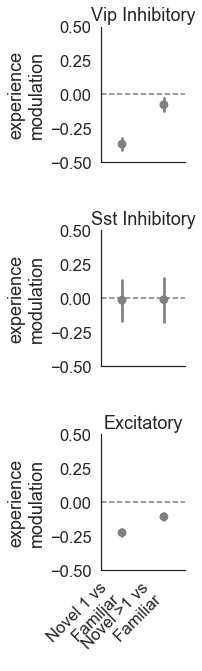

In [135]:
data = df.copy()

metric = 'value'
x = 'comparison'
xorder = np.sort(data[x].unique())

colors = utils.get_experience_level_colors()
figsize = (1.5,10)
fig, ax = plt.subplots(3,1, figsize=figsize, sharex=True, sharey=True)
for i,cell_type in enumerate(cell_types):
    ct_data = data[data.cell_type==cell_type]
#     ax[i] = sns.barplot(data=ct_data,  x=x, order=xorder, y=metric, dodge=0.5, ax=ax[i])
#     change_width(ax[i], 0.3) 
    ax[i] = sns.pointplot(data=ct_data, xorder=xorder, join=False,
                                x=x, y=metric, color='gray', ax=ax[i], zorder=0)

    ax[i].axhline(y=0, xmin=0, xmax=1, color='gray', linestyle='--')
    ax[i].set_title(cell_type)
    ax[i].set_xlabel('')
    ax[i].set_ylim(-0.5, 0.5)
    ax[i].set_xticklabels([x.split('.')[0]+'\n'+x.split('.')[1] for x in xorder], rotation=45, ha='right')
    ax[i].set_ylabel('experience\nmodulation')
#     ax[i].set_ylim(-1.1, 1.1)
# fig.tight_layout()
# fig.suptitle('closest active', x=0.53, y=1.02)
fig.subplots_adjust(hspace=0.5)
utils.save_figure(fig, figsize, save_dir, 'metric_distributions', 'experience_modulation_'+event_type)

### epoch df for changes or omissions

In [183]:
def annotate_epoch_df(epoch_df): 
    """
    Removes truncated 7th epoch and adds 'experience_epoch' column to plot epochs per experience level
    """
    
    # get rid of short 7th epoch (just a few mins at end of session)
    epoch_df = epoch_df[epoch_df.epoch!=6]

    # add experience epoch column
    def merge_experience_epoch(row):
        return row.experience_level+' epoch '+str(int(row.epoch)+1)

    epoch_df['experience_epoch'] = epoch_df[['experience_level', 'epoch']].apply(axis=1, func=merge_experience_epoch)
    
    return epoch_df

In [184]:
# params for stim response df creation
data_type = 'events'
event_type = 'omissions'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted', 'epoch']

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'active_only'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

omission_epoch_mdf = annotate_epoch_df(omission_epoch_mdf)

there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028B5DE59860>,
      dtype=object)

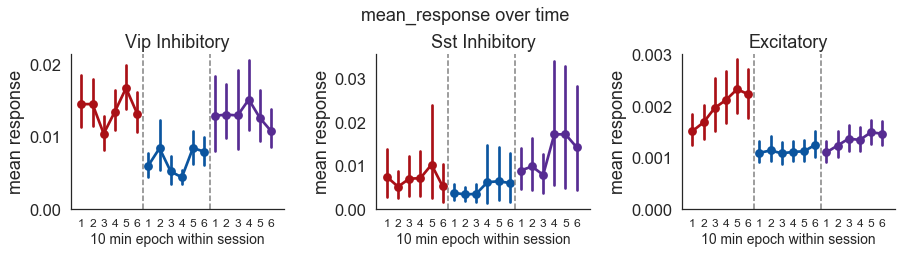

In [189]:
df = omission_epoch_mdf.copy()
# responsive_csids = df[df.fraction_significant_p_value_gray_screen>0.1].cell_specimen_id.unique()
# df = df[df.cell_specimen_id.isin(responsive_csids)]

ppf.plot_mean_response_by_epoch(df, metric='mean_response', save_dir=save_dir, folder='epochs', suffix=suffix)

### changes

In [187]:
# params for stim response df creation
data_type = 'events'
event_type = 'changes'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change', 'epoch']

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
# inclusion_criteria = 'active_only'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)

no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_A
no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_A_passive
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_A
there are 1435 experiments in the full multi_session_df
there are 799 experiments in the multi_session_df after limiting to platform experiments
there are 141 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028B7749AEB8>,
      dtype=object)

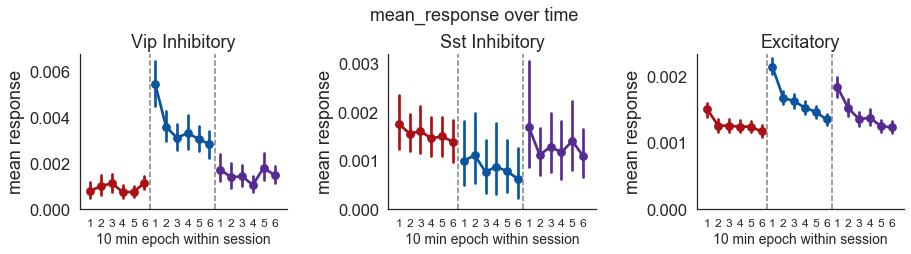

In [188]:
df = change_epoch_mdf.copy()
# responsive_csids = df[df.fraction_significant_p_value_gray_screen>0.1].cell_specimen_id.unique()
# df = df[df.cell_specimen_id.isin(responsive_csids)]

ppf.plot_mean_response_by_epoch(df, metric='mean_response', save_dir=save_dir, folder='epochs', suffix=suffix)

### epochs with changes and omissions together

In [27]:
def plot_mean_response_by_epoch_for_multiple_conditions(response_df_dict, metric='mean_response', horizontal=True,
                                                        use_alpha=True, 
                                                        save_dir=None, folder='epochs', suffix=''):
    """
    Plots the mean metric value across 10 minute epochs, for two different conditions (multi_session_dfs)
    The two conditions are defined by the multi_session_dfs passed in the response_df_dict, 
    which should have two keys, one for the name of each multi_session_df, and the values are the multi_session_dfs
    :param response_df_dict: dictionary containing two dataframes of cell activity with one row per cell_specimen_id / ophys_experiment_id
                            must include columns 'cell_type', 'experience_level', 'epoch', and a column for the metric provided (ex: 'mean_response')
    :param metric: metric value to average over epochs, must be a column of df
    :param save_dir: top level directory to save figure to
    :param folder: folder within save_dir to save figure to; will create folder if it doesnt exist
    :param suffix: string to append at end of saved filename
    :param use_alpha: If True, will plot the two conditions as light and dark versions of experience level colors
                      If False, will plot the two conditions as black and gray lines
    :return:
    """
    
    df_names = list(response_df_dict.keys())
#     # annotate response dfs with 'experience_epoch' column if they dont already have it
#     for df_name in df_names:
#         if 'experience_epoch' not in response_df_dict[df_name].keys():
#             response_df_dict[df_name] = annotate_epoch_df(response_df_dict[df_name])
    
    # get xtick values from one of the dfs
    df = response_df_dict[df_names[0]]
    xticks = [experience_epoch.split(' ')[-1] for experience_epoch in np.sort(df.experience_epoch.unique())]
    n_epochs = len(np.unique(xticks))
    # get info to plot
    cell_types = np.sort(df.cell_type.unique())[::-1]
    experience_epoch = np.sort(df.experience_epoch.unique())
    palette = utils.get_experience_level_colors()
    
    if horizontal:
        figsize = (13, 3.5)
        fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=False)
    else:
        figsize = (4.5, 10.5)
        fig, ax = plt.subplots(3, 1, figsize=figsize, sharex=False)
    for i,cell_type in enumerate(cell_types):

        if use_alpha:
            # plot second dataframe in light alpha
            df = response_df_dict[df_names[1]]
            data = df[df.cell_type==cell_type]
            ax[i] = sns.pointplot(data=data, x='experience_epoch', y=metric, hue='experience_level',
                               order=experience_epoch, palette=palette, ax=ax[i])
            plt.setp([ax[i].get_children()[:60]], alpha=.3);


            # plot first dataframe in solid colors
            df = response_df_dict[df_names[0]]
            data = df[df.cell_type==cell_type]
            ax[i] = sns.pointplot(data=data, x='experience_epoch', y=metric, hue='experience_level',
                               order=experience_epoch, palette=palette, ax=ax[i])
        
        else: 
            # plot second dataframe in gray
            df = response_df_dict[df_names[1]]
            data = df[df.cell_type==cell_type]
            ax[i] = sns.pointplot(data=data, x='experience_epoch', y=metric, 
                               order=experience_epoch, color='gray', ax=ax[i])


            # plot first dataframe in black
            df = response_df_dict[df_names[0]]
            data = df[df.cell_type==cell_type]
            ax[i] = sns.pointplot(data=data, x='experience_epoch', y=metric,
                               order=experience_epoch, color='black', ax=ax[i])

        ax[i].set_ylim(ymin=0)
        ax[i].set_title(cell_type)
        if use_alpha:
            ax[i].get_legend().remove()
#         else:
#             labels = [list(response_df_dict.keys())[0].split('_')[0], list(response_df_dict.keys())[1].split('_')[0]]
#             ax[2].legend(labels=labels, fontsize=16, loc='upper right')
        xlabel = str(int(60/n_epochs))+ ' min epoch in session'
        ax[i].set_xlabel(xlabel)
        ax[i].set_xticklabels(xticks, fontsize=14)
        ax[i].vlines(x=n_epochs-0.5, ymin=0, ymax=1, color='gray', linestyle='--')
        ax[i].vlines(x=(n_epochs*2)-0.5, ymin=0, ymax=1, color='gray', linestyle='--')
        
        
    plt.suptitle(metric+' over time - '+df_names[0] +', '+ df_names[1] +' - '+ suffix, 
                 x=0.52, y=1.02, fontsize=16)
    fig.tight_layout()
    if save_dir:
        fig_title = metric + '_epochs_' + df_names[0] +'_'+ df_names[1] + suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)

In [28]:
# params for stim response df creation
data_type = 'events'
event_type = 'changes'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change', 'epoch']

# name of folder for saving figures using this mdf
folder = 'changes_all_stim'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'
suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)

there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
# create dict containing two multi_session_dfs to include in the same plot
# second df gets plotted in light color, first in dark
response_df_dict = {}
response_df_dict['change_epoch_mdf'] = change_epoch_mdf
response_df_dict['omission_epoch_mdf'] = omission_epoch_mdf

df_names = list(response_df_dict.keys())

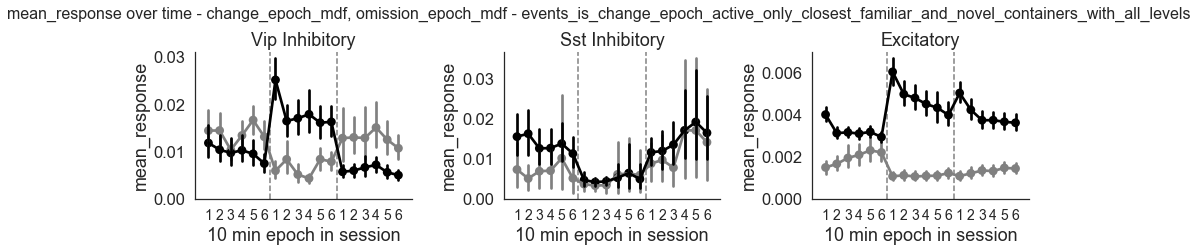

In [30]:
folder = 'epoch_plots'

plot_mean_response_by_epoch_for_multiple_conditions(response_df_dict, metric='mean_response', horizontal=True,
                                                    use_alpha=False, save_dir=save_dir, folder=folder, suffix=suffix)

### try with 20 min epochs

In [31]:
def revise_epoch_annotation(epoch_df): 
    """
    Removes truncated 7th epoch, merges adjacent 10 min epochs into 20 min epochs,
    and adds 'experience_epoch' column to plot epochs per experience level
    """
    
    # get rid of short 7th epoch (just a few mins at end of session)
    epoch_df = epoch_df[epoch_df.epoch!=6]
    
    epoch_df = epoch_df.reset_index()
    epoch_df['epoch_20min'] = None
    epoch_df.at[epoch_df[epoch_df.epoch.isin([0,1])].index.values, 'epoch_20min'] = 1
    epoch_df.at[epoch_df[epoch_df.epoch.isin([2,3])].index.values, 'epoch_20min'] = 2
    epoch_df.at[epoch_df[epoch_df.epoch.isin([4,5])].index.values, 'epoch_20min'] = 3

    # add experience epoch column
    def merge_experience_epoch(row):
        return row.experience_level+' epoch '+str(int(row.epoch_20min))

    epoch_df['experience_epoch'] = epoch_df[['experience_level', 'epoch_20min']].apply(axis=1, func=merge_experience_epoch)
    
    return epoch_df

In [32]:
new_response_df_dict = {}
for key in list(response_df_dict.keys()):
    new_response_df_dict[key] = revise_epoch_annotation(response_df_dict[key])

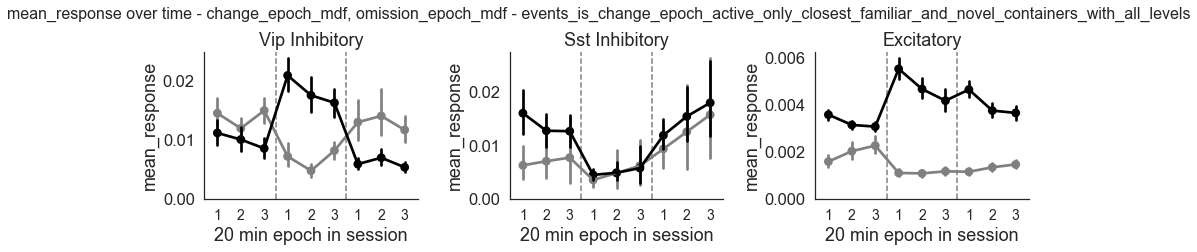

In [33]:
folder = 'epoch_plots'

plot_mean_response_by_epoch_for_multiple_conditions(new_response_df_dict, metric='mean_response', horizontal=True,
                                                    use_alpha=False, save_dir=save_dir, folder=folder, suffix=suffix)

In [34]:
new_response_df_dict[key].epoch.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [35]:
np.unique([experience_epoch.split(' ')[-1] for experience_epoch in np.sort(new_response_df_dict[key].experience_epoch.unique())])

array(['1', '2', '3'], dtype='<U1')

### try for running

In [151]:
def make_figure_2(multi_session_df, multi_session_epoch_df, data_type, event_type):
    """
    multi_session_df: dataframe with rows for cell_specimen_ids / ophys_experiment_ids containing columns for
                        'mean_trace', 'trace_timestamps', 'mean_response', 'p_value_significant_gray_screen'
                        for a set of conditions
    multi_session_epoch_df: dataframe containing the same information, but grouped by 10 minute epochs within sessions
                            dataframe should have column 'experience_epoch' in addition to those listed above
    data_type: 'events', 'filtered_events', 'dff', 'pupil_width', 'running_speed', or 'lick_rate'
    event_type: 'changes', 'omissions', or 'all'
    """

#     sns.despine(offset=10, trim=True);
    
    # define the figure panel
#     figure = plt.figure(figsize=(11,8.5))
    figure = plt.figure(figsize=(11*1.2,8.5*1.2))

    # for mean response epochs plot, set ymin to 0 when looking at physio but do not set ymin otherwise
    if ('pupil' in data_type) or ('running' in data_type) or ('lick' in data_type):
        behavior = True
        ylim = None
        ymin = None
    else: 
        behavior = False
        ylim = (0,1)
        ymin = 0
        

    # define the axes, including their relative location, using figrid
    ax = {
        'panel_A': fg.place_axes_on_grid(figure, xspan=[0.05, 0.3], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
        'panel_B': fg.place_axes_on_grid(figure, xspan=[0.425, 0.6], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
        'panel_C': fg.place_axes_on_grid(figure, xspan=[0.725, 1], yspan=[0.05, 0.95], dim=[3, 1], hspace=0.5, wspace=0.5, sharex=True),
    }

    # call functions that make plots
    palette = utilities.get_experience_level_colors()
    ax['panel_A'] = ppf.plot_population_averages_for_conditions(multi_session_df, data_type, event_type, 
                                            axes_column='cell_type', hue_column='experience_level', 
                                            xlim_seconds=[-1, 1.5], palette=palette, horizontal=False, 
                                            save_dir=None, folder=None, 
                                            suffix=suffix, ax=ax['panel_A'])
    
    if behavior: # if its a behavior data_type use mean response
        ax['panel_B'] = ppf.plot_average_metric_value_for_experience_levels_across_containers(multi_session_df, metric='mean_response',
                                                                                              ylim=ylim, horizontal=True, save_dir=None, 
                                                                                              folder=None, suffix='', ax=ax['panel_B'])
    else: # plot responsive cells
        ax['panel_B'] = ppf.plot_fraction_responsive_cells(multi_session_df, responsiveness_threshold=0.1, ylim=ylim,
                                    save_dir=None, folder=None, suffix=suffix, horizontal=False, ax=ax['panel_B'])

    ax['panel_C'] = ppf.plot_mean_response_by_epoch(multi_session_epoch_df, metric='mean_response', 
                                                    horizontal=False, ymin=ymin,
                                                    save_dir=None, folder=None, suffix=suffix, ax=ax['panel_C'])
        
    # add labels
    labels = [
        {'label_text':'A', 'xpos':0, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
        {'label_text':'B', 'xpos':0.325, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
        {'label_text':'C', 'xpos':0.65, 'ypos':0.0, 'fontsize':20, 'weight': 'bold', 'ha': 'right', 'va': 'bottom'},
    ]
    fg.add_labels(figure, labels)
    
#     sns.despine(offset=10, trim=True);

    return figure

there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels
there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



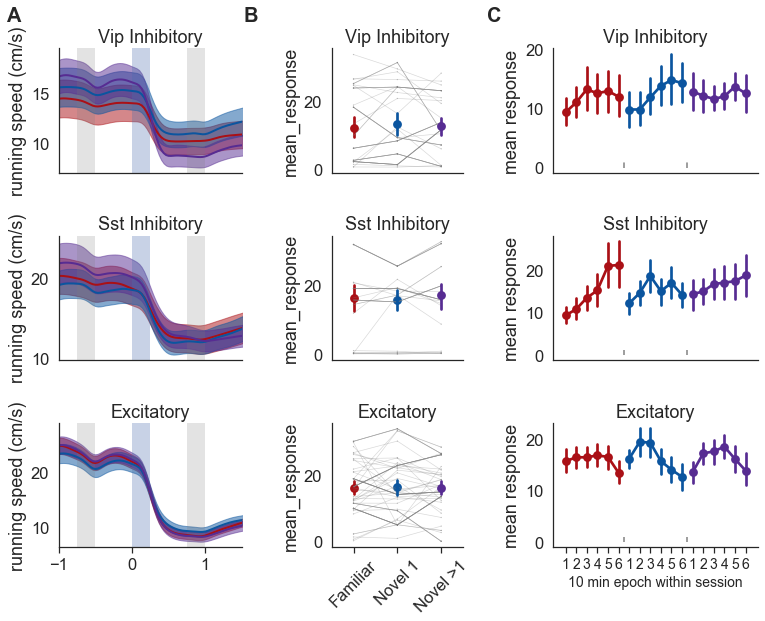

In [153]:
# params for stim response df creation
data_type = 'running_speed'
event_type = 'changes'

# set inclusion criteria
# options: ['full_dataset', 'active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# change response
conditions = ['ophys_experiment_id', 'is_change']
change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

# set suffix for figure saving
suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

# change response over epochs
conditions = ['ophys_experiment_id', 'is_change', 'epoch']
change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)
change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)

figure = make_figure_2(change_mdf, change_epoch_mdf, data_type, event_type)

utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, folder='behavior_pop_averages', fig_title=suffix)

### all behavior types on same plot for changes 

In [196]:
def plot_population_averages_for_behavior(multi_session_df, data_types, event_type, axes_column, hue_column, 
                                          ylabels=None,
                                            project_code=None, timestamps=None, palette=None, title=None, suptitle=None,
                                            horizontal=True, xlim_seconds=None, save_dir=None, folder=None, suffix='', ax=None):
    if palette is None:
        palette = utils.get_experience_level_colors()

    sdf = multi_session_df.copy()
    if 'trace_timestamps' in sdf.keys():
        timestamps = sdf.trace_timestamps.values[0]
    elif timestamps is not None:
        timestamps = timestamps
    else:
        print('provide timestamps or provide a multi_session_df with a trace_timestamps column')

    if project_code is not None:
        # remove traces with incorrect length - why does this happen?
        sdf = sdf.reset_index(drop=True)
        indices = [index for index in sdf.index if len(sdf.iloc[index].mean_trace) == len(sdf.mean_trace.values[100])]
        sdf = sdf.loc[indices]

    if xlim_seconds is None:
        xlim_seconds = [timestamps[0], timestamps[-1]]

    if event_type == 'omissions':
        omitted = True
        change = False
        xlabel = 'time after omission (s)'
    elif event_type == 'changes':
        omitted = False
        change = True
        xlabel = 'time after change (s)'
    else:
        omitted = False
        change = False
        xlabel = 'time (s)'

    if hue_column == 'experience_level':
        hue_conditions = ['Familiar', 'Novel 1', 'Novel >1']
    else:
        hue_conditions = np.sort(sdf[hue_column].unique())
    if axes_column == 'experience_level':
        axes_conditions = ['Familiar', 'Novel 1', 'Novel >1']
    else:
        axes_conditions = data_types
#         axes_conditions = np.sort(sdf[axes_column].unique())[::-1]
    # if there is only one axis condition, set n conditions for plotting to 2 so it can still iterate
    if len(axes_conditions) == 1:
        n_axes_conditions = 2
    else:
        n_axes_conditions = len(axes_conditions)
    if ax is None:
        figsize = (5 * n_axes_conditions, 3)
        fig, ax = plt.subplots(1, n_axes_conditions, figsize=figsize, sharey=False)
    for i, axis in enumerate(axes_conditions):
        for c, hue in enumerate(hue_conditions):
            # try:
            cdf = sdf[(sdf[axes_column] == axis) & (sdf[hue_column] == hue)]
            traces = cdf.mean_trace.values
            #             traces = [trace for trace in traces if np.amax(trace) < 4]
            ax[i] = utils.plot_mean_trace(np.asarray(traces), timestamps, ylabel=ylabels[i],
                                          legend_label=hue, color=palette[c], interval_sec=1,
                                          xlim_seconds=xlim_seconds, ax=ax[i])
            ax[i] = utils.plot_flashes_on_trace(ax[i], timestamps, change=change, omitted=omitted)
            if omitted:
                omission_color = sns.color_palette()[9]
                ax[i].axvline(x=0, ymin=0, ymax=1, linestyle='--', color=omission_color)
            if title == 'metadata':
                metadata_string = utils.get_container_metadata_string(utils.get_metadata_for_row_of_multi_session_df(cdf))
                ax[i].set_title(metadata_string)
            else:
                ax[i].set_title(axis.split('_')[0]+' '+axis.split('_')[1])
            ax[i].set_xlim(xlim_seconds)
            ax[i].set_xlabel(xlabel, fontsize=16)
            ax[i].set_ylabel(ylabels[i])

    fig.subplots_adjust(wspace=0.5)
    if save_dir:
        fig_title = 'population_average_behavior_timeseries_' + axes_column + '_' + hue_column + '_' + suffix
        utils.save_figure(fig, figsize, save_dir, folder, fig_title)

    return ax


In [176]:
# params for stim response df creation
event_type = 'changes'

# set inclusion criteria
# options: ['full_dataset', 'active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# change response
conditions = ['ophys_experiment_id', 'is_change']

data_type = 'running_speed'
run_change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

data_type = 'pupil_width'
pupil_change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

data_type = 'lick_rate'
lick_change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)


there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels
there are 1882 experiments in the full multi_session_df
there are 1246 experiments in the multi_session_df after limiting to platform experiments
there are 399 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels
there are 1602 experiments in the full multi_session_df
there are 1062 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


In [200]:
run_change_mdf['data_type'] = 'running_speed'
pupil_change_mdf['data_type'] = 'pupil_width'
lick_change_mdf['data_type'] = 'lick_rate'

multi_session_df = pd.concat([run_change_mdf, pupil_change_mdf, lick_change_mdf])

FileNotFoundError: [Errno 2] No such file or directory: '\\\\allen\\programs\\braintv\\workgroups\\nc-ophys\\visual_behavior\\platform_paper_plots\\figure_2\\behavior_pop_averages\\population_average_behavior_timeseries_data_type_experience_level_events_is_change_epoch_active_only_closest_familiar_and_novel_containers_with_all_levels.png'

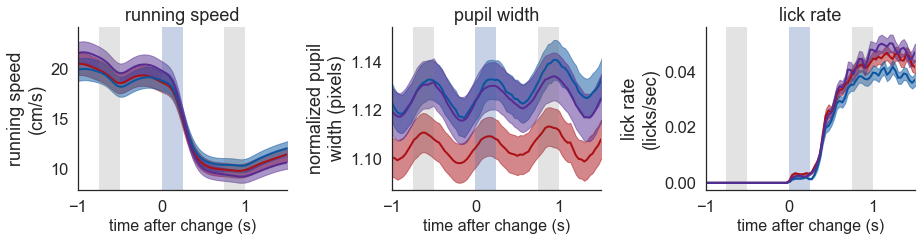

In [201]:
event_type = 'changes'
data_types = ['running_speed', 'pupil_width', 'lick_rate']
ylabels = ['running speed\n(cm/s)', 'normalized pupil\nwidth (pixels)', 'lick rate\n(licks/sec)']

plot_population_averages_for_behavior(multi_session_df, data_types=data_types, event_type=event_type,
                                            axes_column='data_type', hue_column='experience_level', 
                                            xlim_seconds=[-1, 1.5], palette=palette, horizontal=True, 
                                            ylabels=ylabels, 
                                            save_dir=save_dir, folder='behavior_pop_averages', 
                                            suffix=suffix, ax=None)


### omissions 

In [180]:
# params for stim response df creation
event_type = 'omissions'

# set inclusion criteria
# options: ['full_dataset', 'active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'

# change response
conditions = ['ophys_experiment_id', 'omitted']

data_type = 'running_speed'
run_omission_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

data_type = 'pupil_width'
pupil_omission_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)

data_type = 'lick_rate'
lick_omission_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)


there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels
there are 1882 experiments in the full multi_session_df
there are 1246 experiments in the multi_session_df after limiting to platform experiments
there are 399 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels
there are 1602 experiments in the full multi_session_df
there are 1062 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels


In [198]:
run_omission_mdf['data_type'] = 'running_speed'
pupil_omission_mdf['data_type'] = 'pupil_width'
lick_omission_mdf['data_type'] = 'lick_rate'

multi_session_df = pd.concat([run_omission_mdf, pupil_omission_mdf, lick_omission_mdf])

FileNotFoundError: [Errno 2] No such file or directory: '\\\\allen\\programs\\braintv\\workgroups\\nc-ophys\\visual_behavior\\platform_paper_plots\\figure_2\\behavior_pop_averages\\population_average_behavior_timeseries_data_type_experience_level_events_is_change_epoch_active_only_closest_familiar_and_novel_containers_with_all_levels.png'

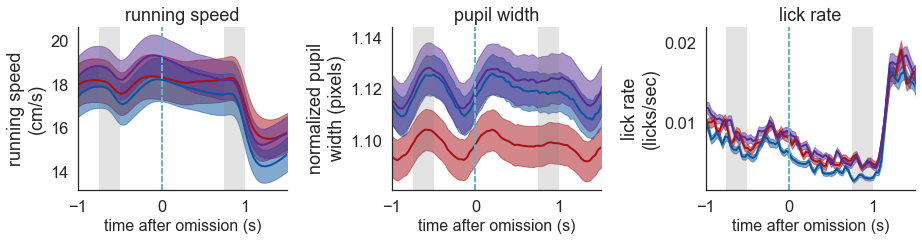

In [199]:
event_type = 'omissions'
data_types = ['running_speed', 'pupil_width', 'lick_rate']
ylabels = ['running speed\n(cm/s)', 'normalized pupil\nwidth (pixels)', 'lick rate\n(licks/sec)']

plot_population_averages_for_behavior(multi_session_df, data_types=data_types, event_type=event_type,
                                            axes_column='data_type', hue_column='experience_level', 
                                            xlim_seconds=[-1, 1.5], palette=palette, horizontal=True, 
                                            ylabels=ylabels, 
                                            save_dir=save_dir, folder='behavior_pop_averages', 
                                            suffix=suffix, ax=None)


### changes, all data_types and inclusion criteria, limited to engaged state

In [37]:
# event_type = 'changes'
# data_types = ['events', 'filtered_events', 'dff']

# # set inclusion criteria
# inclusion_criteria = ['full_dataset', 'active_only', 
#                       'active_only_closest_familiar_and_novel_containers_with_all_levels']

# for data_type in data_types: 
#     for inclusion_criterion in inclusion_criteria:
#         # change response
#         conditions = ['cell_specimen_id', 'engagement_state', 'is_change']
#         change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_mdf = change_mdf[change_mdf.engagement_state=='engaged']

#         # set suffix for figure saving
#         suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criterion

#         # change response over epochs
#         conditions = ['cell_specimen_id', 'engagement_state', 'is_change', 'epoch']
#         change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)
#         change_epoch_mdf = change_epoch_mdf[change_epoch_mdf.engagement_state=='engaged']

#         figure = make_figure_2(change_mdf, change_epoch_mdf, data_type, event_type)

#         utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, folder='compare_conditions', fig_title=suffix)

In [38]:
# event_type = 'changes'
# data_types = ['pupil_width', 'running_speed', 'lick_rate']

# # set inclusion criteria
# inclusion_criteria = ['full_dataset', 'active_only', 
#                       'active_only_closest_familiar_and_novel_containers_with_all_levels']

# for data_type in data_types: 
#     for inclusion_criterion in inclusion_criteria: 
#         # change response
#         conditions = ['ophys_experiment_id', 'engagement_state', 'is_change']
#         change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_mdf = change_mdf[change_mdf.engagement_state=='engaged']

#         # set suffix for figure saving
#         suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criterion
#         print('******', suffix, '******')

#         # change response over epochs
#         conditions = ['ophys_experiment_id', 'engagement_state', 'is_change', 'epoch']
#         change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)
#         change_epoch_mdf = change_epoch_mdf[change_epoch_mdf.engagement_state=='engaged']

#         figure = make_figure_2(change_mdf, change_epoch_mdf, data_type, event_type)

#         utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, folder='compare_conditions', fig_title=suffix)

### omissions, all data types and inclusion criteria, limited to engaged state

In [39]:
# event_type = 'omissions'
# data_types = ['events', 'filtered_events', 'dff']

# # set inclusion criteria
# # set inclusion criteria
# inclusion_criteria = ['full_dataset', 'active_only', 
#                       'active_only_closest_familiar_and_novel_containers_with_all_levels']

# for data_type in data_types: 
#     for inclusion_criterion in inclusion_criteria:
#         # change response
#         conditions = ['cell_specimen_id', 'engagement_state', 'omitted']
#         change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_mdf = change_mdf[change_mdf.engagement_state=='engaged']
        
#         # set suffix for figure saving
#         suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criterion
#         print('******', suffix, '******')

#         # change response over epochs
#         conditions = ['cell_specimen_id', 'engagement_state', 'omitted', 'epoch']
#         change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)
#         change_epoch_mdf = change_epoch_mdf[change_epoch_mdf.engagement_state=='engaged']

#         figure = make_figure_2(change_mdf, change_epoch_mdf, data_type, event_type)

#         utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, 
#                           folder='compare_conditions', fig_title=suffix)

In [40]:
# event_type = 'omissions'
# data_types = ['pupil_width', 'running_speed', 'lick_rate']

# # set inclusion criteria
# # set inclusion criteria
# inclusion_criteria = ['full_dataset', 'active_only', 
#                       'active_only_closest_familiar_and_novel_containers_with_all_levels']

# for data_type in data_types: 
#     for inclusion_criterion in inclusion_criteria:
#         # change response
#         conditions = ['ophys_experiment_id', 'engagement_state', 'omitted']
#         change_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_mdf = change_mdf[change_mdf.engagement_state=='engaged']
        
#         # set suffix for figure saving
#         suffix = get_conditions_string(data_type, conditions)+'_'+inclusion_criterion
#         print('******', suffix, '******')

#         # change response over epochs
#         conditions = ['ophys_experiment_id', 'engagement_state', 'omitted', 'epoch']
#         change_epoch_mdf = get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criterion)
#         change_epoch_mdf = annotate_epoch_df(change_epoch_mdf)
#         change_epoch_mdf = change_epoch_mdf[change_epoch_mdf.engagement_state=='engaged']

#         figure = make_figure_2(change_mdf, change_epoch_mdf, data_type, event_type)

#         utils.save_figure(fig=figure, figsize=(11*1.2,8.5*1.2), save_dir=save_dir, 
#                           folder='compare_conditions', fig_title=suffix)